In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [ ]:
raw_data = pd.read_excel("/content/drive/MyDrive/6671501a18c55_round2_input.xlsx").convert_dtypes()
raw_data['dismissed'] = raw_data['wicket kind'].notnull().astype(int)
print(raw_data.describe())
raw_data.info()
raw_data.head()

            match id      batsman_id  is_batsman_captain  is_batsman_keeper  \
count        24875.0         24875.0             24875.0            24875.0   
mean     9100156.528  4102710.123176            0.113889            0.11397   
min        8587795.0         31464.0                 0.0                0.0   
25%        8778818.0       2231928.0                 0.0                0.0   
50%        9085047.0       3706065.0                 0.0                0.0   
75%        9388448.0       6003584.0                 0.0                0.0   
max        9887856.0       9899140.0                 1.0                1.0   
std    313392.642151  2421528.438688            0.317683           0.317781   

         inning       runs  balls_faced  over_faced_first       bowler_id  \
count   24875.0    24875.0      24875.0           24875.0         18368.0   
mean   1.486312  18.300302    14.129447          9.155811  4332079.693598   
min         1.0        0.0          0.0               1.1

,match id,batsman,batsman_id,batsman_dob,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,...,bowler_dob,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt,ingestion_timestamp,dismissed
0,8587795,AJ Fh,37351,1986-11-17,AUS:Right-hand bat:Slow left-arm orthodox:,1,0,2,14,15,...,1997-02-05,AUS:Right-hand bat:Right-arm fast:,0,0,93.33,1,<NA>,2021-01-08,2022-03-22 12:43:21,1
1,8587795,Md Ni,181404,1985-01-01,AFG:Right-hand bat:Right-arm offbreak:,0,0,2,71,41,...,<NA>,<NA>,<NA>,<NA>,173.17,9,2,2021-01-08,2022-03-22 12:43:21,0
2,8587795,JW Ws,1635773,1988-08-13,AUS:Right-hand bat:Right-arm medium:,0,0,1,16,13,...,<NA>,<NA>,<NA>,<NA>,123.08,1,<NA>,2021-01-08,2022-03-22 12:43:21,0
3,8587795,DR Bs,2170762,1991-04-30,ENG:Right-hand bat:Slow left-arm orthodox:,0,0,1,2,4,...,1991-02-12,AUS:Right-hand bat:Right-arm fast-medium:,0,0,50.0,<NA>,<NA>,2021-01-08,2022-03-22 12:43:21,1
4,8587795,AT Cy,2285051,1991-08-27,AUS:Left-hand bat:None:,1,1,1,42,25,...,1988-12-18,PAK:Left-hand bat:Slow left-arm orthodox:,0,0,168.0,3,3,2021-01-08,2022-03-22 12:43:21,1


# **Metrics For Consistency and Recency:**


# Recency:

Since sample sizes of most players are very small, score calculated over a window of last 3 games is used

# Consistency:

**Batsman:**

std_deviation(strike_rate)/sqrt(matches_played) + std_deviation(runs scored)/sqrt(matches_played)


**Bowlers:**

std_deviation(wickets)/sqrt(matches_played) + std_deviation(economy)/sqrt(matches_played)

# Combined score:

average of standardized recency score and -1 * standardized consistency score (lower consistency score is better)


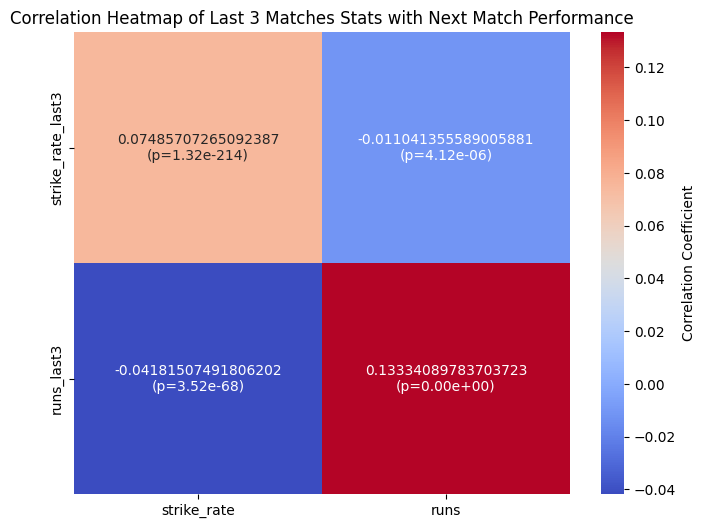

           batsman_id  total_runs  total_balls_faced    times_out  average  \
count          2063.0      2063.0             2063.0  2063.000000   2063.0   
mean   5210708.532719  220.659234         170.368396     9.410567     <NA>   
std    2699286.898444   424.83264          305.52227    14.353667     <NA>   
min           31464.0         0.0                1.0     0.000000     <NA>   
25%         2969500.5        12.0               14.0     1.000000     <NA>   
50%         4950294.0        48.0               45.0     3.000000     <NA>   
75%         7881810.0       213.0              176.5    11.000000     <NA>   
max         9899140.0      4031.0             3083.0   103.000000     <NA>   

       strike_rate      fifties     hundreds  strike_rate_recent  \
count       2063.0  2063.000000  2063.000000              2063.0   
mean    104.034845     1.058652     0.056229           100.32216   
std      44.521223     2.843126     0.327733           49.168123   
min            0.0     0.

In [ ]:
raw_data = raw_data.sort_values(by='match_dt', ascending=False)
#Grouping with batsman_id
grouped = raw_data.groupby('batsman_id')
total_runs = grouped['runs'].sum()
total_balls_faced = grouped['balls_faced'].sum()
times_out = grouped['dismissed'].sum()
innings = grouped.size()
average = total_runs / times_out
strike_rate = (total_runs / total_balls_faced) * 100
fifties = grouped.apply(lambda x: (x['runs'].between(50, 99)).sum())
hundreds = grouped.apply(lambda x: (x['runs'] >= 100).sum())
keeper_status = grouped['is_batsman_keeper'].sum() >= 2


rolling_stats = grouped.rolling(window=3).agg({
    'strike_rate': 'mean',
    'runs': 'mean',
}).shift(1).reset_index()
raw_data = raw_data.merge(rolling_stats, on='batsman_id', suffixes=('', '_last3'))
raw_data = raw_data.dropna()

def corr_with_pvalue(x, y):
    corr, pvalue = pearsonr(x, y)
    return corr, pvalue

# Columns to check
columns_last3 = ['strike_rate_last3', 'runs_last3']
columns_next = ['strike_rate', 'runs']

# DataFrame to store results
results_corr = pd.DataFrame(index=columns_last3, columns=columns_next)
results_pvalue = pd.DataFrame(index=columns_last3, columns=columns_next)

# Calculate correlations and p-values
for col1 in columns_last3:
    for col2 in columns_next:
        corr, pvalue = corr_with_pvalue(raw_data[col1], raw_data[col2])
        results_corr.loc[col1, col2] = corr
        results_pvalue.loc[col1, col2] = pvalue

correlation_matrix = raw_data[['strike_rate_last3', 'runs_last3', 'strike_rate', 'runs']].corr()

# Extract the correlation of last 3 matches stats with next match stats
correlation_with_next_match = correlation_matrix.loc[['strike_rate_last3', 'runs_last3'], ['strike_rate', 'runs']]

annot = results_corr.round(2).astype(str) + "\n(p=" + results_pvalue.applymap(lambda p: f"{p:.2e}").astype(str) + ")"

# Plot heatmap with custom annotations
plt.figure(figsize=(8, 6))
sns.heatmap(results_corr.astype(float), annot=annot, cmap='coolwarm', fmt='', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Last 3 Matches Stats with Next Match Performance')
plt.show()

#Recency metric
grouped_recent = grouped.head(3).groupby('batsman_id')
total_runs_recent = grouped_recent['runs'].sum()
total_balls_faced_recent = grouped_recent['balls_faced'].sum()
times_out_recent = grouped_recent['dismissed'].sum()
average_recent = total_runs_recent / times_out_recent
strike_rate_recent = (total_runs_recent / total_balls_faced_recent) * 100
fifties_recent = grouped_recent.apply(lambda x: (x['runs'].between(50, 99)).sum())
hundreds_recent = grouped_recent.apply(lambda x: (x['runs'] >= 100).sum())

#Consistency metric
runs_std = grouped['runs'].std().fillna(0)
strike_std = grouped['strike_rate'].std().fillna(0)
num_matches_played = grouped.size()
consistency_score = (runs_std / np.sqrt(num_matches_played)) + (strike_std / np.sqrt(num_matches_played))

bat_data = pd.DataFrame({
    'total_runs': total_runs,
    'total_balls_faced': total_balls_faced,
    'times_out': times_out,
    'average': average,
    'strike_rate': strike_rate,
    'fifties': fifties,
    'hundreds': hundreds,
    'is_keeper': keeper_status,
    'strike_rate_recent': strike_rate_recent,
    'average_recent': average_recent,
    'fifties_recent': fifties_recent,
    'hundreds_recent': hundreds_recent,
    'consistency_score': consistency_score,
    'matches_played': innings
}).reset_index()

print(bat_data.describe())

In [ ]:
def score_tier(value, tiers, scores):
    for i, tier in enumerate(tiers):
        if value >= tier:
            return scores[i]
    return scores[-1]

# Define tiers and scores for each metric
strike_rate_tiers = [150, 100, 80]
strike_rate_scores = [50, 40, 30, 0]

average_tiers = [50, 40, 30]
average_scores = [30, 20, 10, 5]

hundreds_tiers = [3, 2, 1]
hundreds_scores = [30, 20, 10, 0]

fifties_tiers = [5, 3, 1]
fifties_scores = [20, 10, 5, 0]

# Apply the scoring function to each metric
bat_data['strike_rate_score'] = bat_data['strike_rate'].apply(score_tier, args=(strike_rate_tiers, strike_rate_scores))
bat_data['average_score'] = bat_data['average'].apply(score_tier, args=(average_tiers, average_scores))
bat_data['hundreds_score'] = bat_data['hundreds'].apply(score_tier, args=(hundreds_tiers, hundreds_scores))
bat_data['fifties_score'] = bat_data['fifties'].apply(score_tier, args=(fifties_tiers, fifties_scores))
bat_data['total_score'] = (bat_data['strike_rate_score'] + bat_data['average_score'] + bat_data['hundreds_score'] + bat_data['fifties_score'])

#Apply scoring for recent metrics
bat_data['striking_rate_score_recent'] = bat_data['strike_rate_recent'].apply(score_tier, args=(strike_rate_tiers, strike_rate_scores))
bat_data['average_score_recent'] = bat_data['average_recent'].apply(score_tier, args=(average_tiers, average_scores))
bat_data['hundreds_score_recent'] = bat_data['hundreds_recent'].apply(score_tier, args=(hundreds_tiers, hundreds_scores))
bat_data['fifties_score_recent'] = bat_data['fifties_recent'].apply(score_tier, args=(fifties_tiers, fifties_scores))
bat_data['total_score_recent'] = (bat_data['striking_rate_score_recent'] + bat_data['average_score_recent'] + bat_data['hundreds_score_recent'] + bat_data['fifties_score_recent'])

#Standardizing and combining recency and consistency metrics
bat_data['z_recent_score'] = (bat_data['total_score_recent'] - bat_data['total_score_recent'].mean()) / bat_data['total_score_recent'].std()
bat_data['z_consistency_score'] = -1 * (bat_data['consistency_score'] - bat_data['consistency_score'].min()) / bat_data['consistency_score'].std()
bat_data['z_consistency_score'] = bat_data['z_consistency_score'] - bat_data['z_consistency_score'].mean()
bat_data['combined_score'] = (bat_data['z_recent_score'] + bat_data['z_consistency_score']) / 2

print(bat_data[bat_data['total_runs'] > 100]['matches_played'].describe())

count    786.000000
mean      25.919847
std       20.873961
min        2.000000
25%       11.000000
50%       19.000000
75%       33.000000
max      119.000000
Name: matches_played, dtype: float64


In [ ]:
keepers = bat_data[bat_data['is_keeper']].sort_values('total_score', ascending=False).head(5)[['batsman_id','total_score','total_score_recent','consistency_score','combined_score']]
print(keepers)

     batsman_id  total_score  total_score_recent  consistency_score  \
962     4635658          110                  75          11.095098   
304     2162782          110                  65           9.144029   
337     2263736          110                  75            7.61417   
550     3057312          100                  35            11.8635   
509     2954769          100                  45          12.742166   

     combined_score  
962        1.068456  
304        0.905506  
337         1.15661  
550        0.199555  
509        0.389663  


batsman 2263736 has a better recent score and a better consistency score so he will be the keeper

In [ ]:
bat_data[bat_data['batsman_id'] ==  2263736]

,batsman_id,total_runs,total_balls_faced,times_out,average,strike_rate,fifties,hundreds,is_keeper,strike_rate_recent,...,fifties_score,total_score,striking_rate_score_recent,average_score_recent,hundreds_score_recent,fifties_score_recent,total_score_recent,z_recent_score,z_consistency_score,combined_score
337,2263736,4031,3083,72,55.986111,130.74927,38,2,True,136.585366,...,20,110,40,30,0,5,75,1.611385,0.701834,1.15661


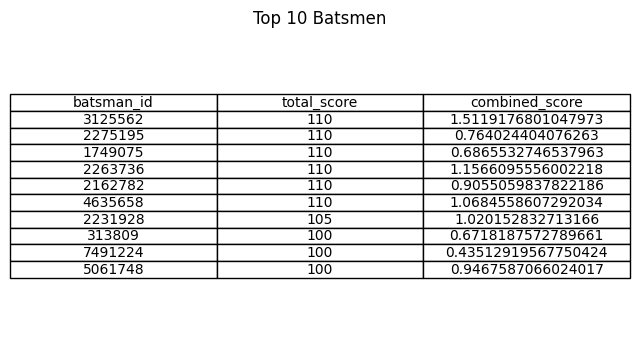

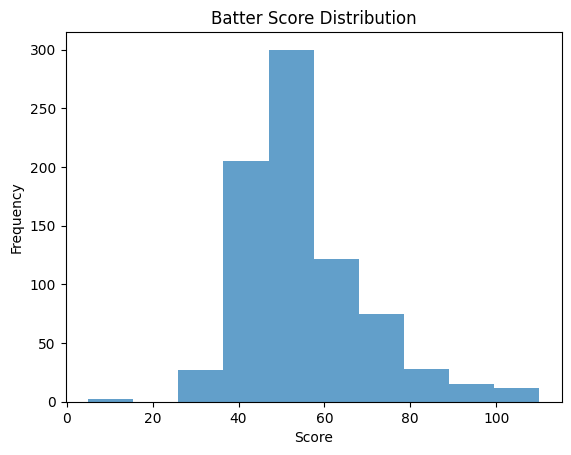

In [ ]:
batters = bat_data[bat_data['total_runs'] > 100].sort_values('total_score', ascending=False).head(10)[['batsman_id','total_score','combined_score']]
fig, ax = plt.subplots(figsize=(8, 4))  # Set figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=batters.values, colLabels=batters.columns, cellLoc='center', loc='center')
plt.title('Top 10 Batsmen')
# Save the table as an image
plt.savefig('bat.png', bbox_inches='tight', dpi=300)
plt.show()
plt.hist(bat_data[bat_data['total_runs'] > 100]['total_score'], bins=10, alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Batter Score Distribution')
plt.show()


In [ ]:
batters[batters['total_score'] == 110].sort_values('combined_score', ascending=False).head(10)

,batsman_id,total_score,combined_score
574,3125562,110,1.511918
337,2263736,110,1.15661
962,4635658,110,1.068456
304,2162782,110,0.905506
341,2275195,110,0.764024
197,1749075,110,0.686553


In [ ]:
bat_data[bat_data['batsman_id'] ==  1749075]

,batsman_id,total_runs,total_balls_faced,times_out,average,strike_rate,fifties,hundreds,is_keeper,strike_rate_recent,...,fifties_score,total_score,striking_rate_score_recent,average_score_recent,hundreds_score_recent,fifties_score_recent,total_score_recent,z_recent_score,z_consistency_score,combined_score
197,1749075,3203,2085,103,31.097087,153.621103,20,3,False,162.962963,...,20,110,50,5,0,0,55,0.761944,0.611162,0.686553


In [ ]:
bat_data[bat_data['batsman_id'] ==  3125562]

,batsman_id,total_runs,total_balls_faced,times_out,average,strike_rate,fifties,hundreds,is_keeper,strike_rate_recent,...,fifties_score,total_score,striking_rate_score_recent,average_score_recent,hundreds_score_recent,fifties_score_recent,total_score_recent,z_recent_score,z_consistency_score,combined_score
574,3125562,2551,1612,72,35.430556,158.25062,19,4,False,162.626263,...,20,110,50,30,10,5,95,2.460826,0.563009,1.511918


In [ ]:
bat_data[bat_data['batsman_id'] ==  2275195]

,batsman_id,total_runs,total_balls_faced,times_out,average,strike_rate,fifties,hundreds,is_keeper,strike_rate_recent,...,fifties_score,total_score,striking_rate_score_recent,average_score_recent,hundreds_score_recent,fifties_score_recent,total_score_recent,z_recent_score,z_consistency_score,combined_score
341,2275195,2480,1602,81,30.617284,154.806492,14,3,False,174.418605,...,20,110,50,10,0,0,60,0.974304,0.553744,0.764024


In [ ]:
raw_bow_data = pd.read_excel("/content/drive/MyDrive/bowler_input.xlsx").convert_dtypes()
raw_bow_data.describe()
raw_bow_data['economy'] = (raw_bow_data['runs'] / raw_bow_data['balls_bowled']) * 6
raw_bow_data = raw_bow_data.sort_values('match_dt', ascending=False)

In [ ]:
raw_bow_data.head()

,match id,bowler,bowler_id,bowler_dob,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt,ingestion_timestamp
18480,9717518,Sl Im,6930286,2001-06-03,BAN:Left-hand bat:Left-arm medium-fast:,0,0,2,17,2,22,4.636364,0,15,2,0,3,0,2023-12-31,2024-03-14 17:12:36.995
18435,9702804,WA Ar,6718844,1997-02-05,AUS:Right-hand bat:Right-arm fast:,0,0,2,37,1,18,12.333333,0,6,6,0,2,1,2023-12-31,2024-03-14 17:12:36.995
18425,9702804,Id Wm,1594319,1988-12-18,PAK:Left-hand bat:Slow left-arm orthodox:,0,0,1,40,0,24,10.0,0,6,4,1,1,0,2023-12-31,2024-03-14 17:12:36.995
18426,9702804,MP Ss,2275097,1989-08-16,AUS:Right-hand bat:Right-arm medium:,0,0,1,29,0,12,14.5,0,4,2,3,0,0,2023-12-31,2024-03-14 17:12:36.995
18427,9702804,GJ Ml,2275195,1988-10-14,AUS:Right-hand bat:Right-arm offbreak:,1,0,1,21,2,18,7.0,0,7,3,0,0,0,2023-12-31,2024-03-14 17:12:36.995


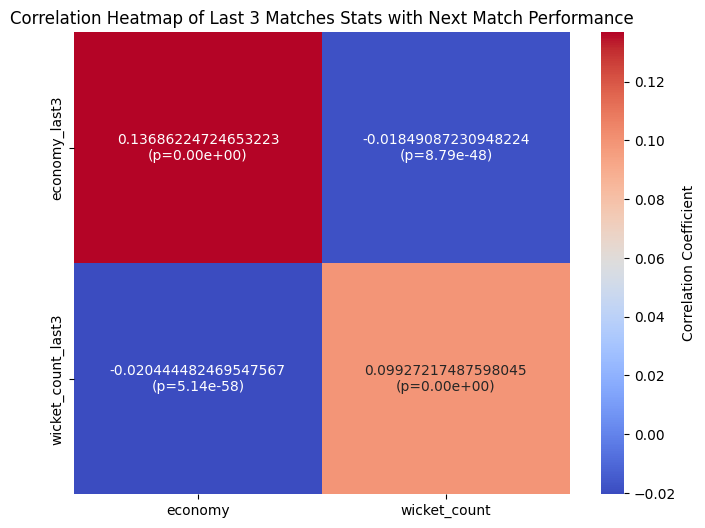

            bowler_id  total_runs_conceded  total_balls_bowled  \
count          1511.0               1511.0              1511.0   
mean   5408833.405692           312.871608          233.491727   
std    2696220.755774           447.636077          341.172163   
min           34061.0                  0.0                 1.0   
25%         3117403.5                 41.0                25.0   
50%         5425146.0                125.0                92.0   
75%         8056061.0                394.5               294.0   
max         9888584.0               3353.0              2977.0   

       total_wickets_taken  strike_rate    average   economy  \
count               1511.0       1511.0     1511.0    1511.0   
mean             12.385175          inf        inf  8.529593   
std              19.288844         <NA>       <NA>   2.50916   
min                    0.0          3.0        0.0       0.0   
25%                    1.0    16.123966  21.411826  7.222222   
50%                  

In [ ]:
#Grouping data using bowler_id
grouped = raw_bow_data.groupby('bowler_id')
total_runs_conceded = grouped['runs'].sum()
total_balls_bowled = grouped['balls_bowled'].sum()
total_wickets_taken = grouped['wicket_count'].sum()
strike_rate = total_balls_bowled / total_wickets_taken
average = total_runs_conceded / total_wickets_taken
total_overs_bowled = total_balls_bowled / 6
economy = total_runs_conceded / total_overs_bowled
four_wicket_hauls = grouped.apply(lambda x: (x['wicket_count'] >= 4).sum())
wickets_in_matches = grouped.apply(lambda x: (x['wicket_count'] > 0).sum() >= 2)

rolling_stats = grouped.rolling(window=3).agg({
    'economy': 'mean',
    'wicket_count': 'mean',
}).shift(1).reset_index()
raw_bow_data = raw_bow_data.merge(rolling_stats, on='bowler_id', suffixes=('', '_last3'))
raw_bow_data = raw_bow_data.dropna()

# Columns to check
columns_last3 = ['economy_last3', 'wicket_count_last3']
columns_next = ['economy', 'wicket_count']

# DataFrame to store results
results_corr = pd.DataFrame(index=columns_last3, columns=columns_next)
results_pvalue = pd.DataFrame(index=columns_last3, columns=columns_next)

# Calculate correlations and p-values
for col1 in columns_last3:
    for col2 in columns_next:
        corr, pvalue = corr_with_pvalue(raw_bow_data[col1], raw_bow_data[col2])
        results_corr.loc[col1, col2] = corr
        results_pvalue.loc[col1, col2] = pvalue

correlation_matrix = raw_bow_data[['economy_last3', 'wicket_count_last3', 'economy', 'wicket_count']].corr()

# Extract the correlation of last 3 matches stats with next match stats
correlation_with_next_match = correlation_matrix.loc[['economy_last3', 'wicket_count_last3'], ['economy', 'wicket_count']]

annot = results_corr.round(2).astype(str) + "\n(p=" + results_pvalue.applymap(lambda p: f"{p:.2e}").astype(str) + ")"

# Plot heatmap with custom annotations
plt.figure(figsize=(8, 6))
sns.heatmap(results_corr.astype(float), annot=annot, cmap='coolwarm', fmt='', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Last 3 Matches Stats with Next Match Performance')
plt.show()


#Recency metric
grouped_recent = grouped.head(3).groupby('bowler_id')
total_runs_conceded_r = grouped_recent['runs'].sum()
total_balls_bowled_r = grouped_recent['balls_bowled'].sum()
total_wickets_taken_r = grouped_recent['wicket_count'].sum()
strike_rate_r = total_balls_bowled_r / total_wickets_taken_r
average_r = total_runs_conceded_r / total_wickets_taken_r
total_overs_bowled_r = total_balls_bowled_r / 6
economy_r = total_runs_conceded_r / total_overs_bowled_r
four_wicket_hauls_r = grouped_recent.apply(lambda x: (x['wicket_count'] >= 4).sum())

#Consistency metric
wicket_count_std = grouped['wicket_count'].std().fillna(0)
bowlers_economy_std = grouped['economy'].std().fillna(0)
num_matches_played = grouped.size()
consistency_score = (wicket_count_std / np.sqrt(num_matches_played)) + (bowlers_economy_std / np.sqrt(num_matches_played))

bow_data = pd.DataFrame({
    'total_runs_conceded': total_runs_conceded,
    'total_balls_bowled': total_balls_bowled,
    'total_wickets_taken': total_wickets_taken,
    'strike_rate': strike_rate,
    'average': average,
    'economy': economy,
    'four_wicket_hauls': four_wicket_hauls,
    'wickets_in_2_or_more_matches': wickets_in_matches,
    'matches_played': num_matches_played,
    'consistency_score': consistency_score,
    'strike_rate_recent': strike_rate_r,
    'average_recent': average_r,
    'economy_recent': economy_r,
    'four_wicket_hauls_recent': four_wicket_hauls_r
}).reset_index()

print(bow_data.describe())

In [ ]:
def score_tier_l(value, tiers, scores):
    for i, tier in enumerate(tiers):
        if value <= tier:
            return scores[i]
    return scores[-1]

def econ_score(value):
    if value <= 3:
        return 50
    if value <= 5:
        return 40
    if value < 7:
        return 30
    return 0

strike_rate_tiers = [15, 19, 24]
strike_rate_scores = [30, 20, 10, 0]

average_tiers = [20, 30, 40]
average_scores = [30, 20, 10, 0]

four_wicket_hauls_tiers = [4, 2, 1]
four_wicket_hauls_scores = [30, 20, 10, 0]

# Apply the scoring function to each metric
bow_data['strike_rate_score'] = bow_data['strike_rate'].apply(score_tier_l, args=(strike_rate_tiers, strike_rate_scores))
bow_data['average_score'] = bow_data['average'].apply(score_tier_l, args=(average_tiers, average_scores))
bow_data['economy_score'] = bow_data['economy'].apply(econ_score)
bow_data['four_wicket_hauls_score'] = bow_data['four_wicket_hauls'].apply(score_tier, args=(four_wicket_hauls_tiers, four_wicket_hauls_scores))
bow_data['total_score'] = (bow_data['strike_rate_score'] + bow_data['average_score'] + bow_data['economy_score'] + bow_data['four_wicket_hauls_score'])
bow_data['strike_rate_score_recent'] = bow_data['strike_rate_recent'].apply(score_tier_l, args=(strike_rate_tiers, strike_rate_scores))
bow_data['average_score_recent'] = bow_data['average_recent'].apply(score_tier_l, args=(average_tiers, average_scores))
bow_data['economy_score_recent'] = bow_data['economy_recent'].apply(econ_score)
bow_data['four_wicket_hauls_score_recent'] = bow_data['four_wicket_hauls_recent'].apply(score_tier, args=(four_wicket_hauls_tiers, four_wicket_hauls_scores))
bow_data['total_score_recent'] = (bow_data['strike_rate_score_recent'] + bow_data['average_score_recent'] + bow_data['economy_score_recent'] + bow_data['four_wicket_hauls_score_recent'])

#Standardizing recency and consistency and taking average
bow_data['z_recent_score'] = (bow_data['total_score_recent'] - bow_data['total_score_recent'].mean()) / bow_data['total_score_recent'].std()
bow_data['z_consistency_score'] = -1 * (bow_data['consistency_score'] - bow_data['consistency_score'].min()) / bow_data['consistency_score'].std()
bow_data['z_consistency_score'] = bow_data['z_consistency_score'] - bow_data['z_consistency_score'].mean()
bow_data['combined_score'] = (bow_data['z_recent_score'] + bow_data['z_consistency_score']) / 2

print(bow_data[bow_data['total_wickets_taken'] >= 10]['matches_played'].describe())

count    513.000000
mean      29.109162
std       19.534819
min        5.000000
25%       15.000000
50%       24.000000
75%       37.000000
max      128.000000
Name: matches_played, dtype: float64


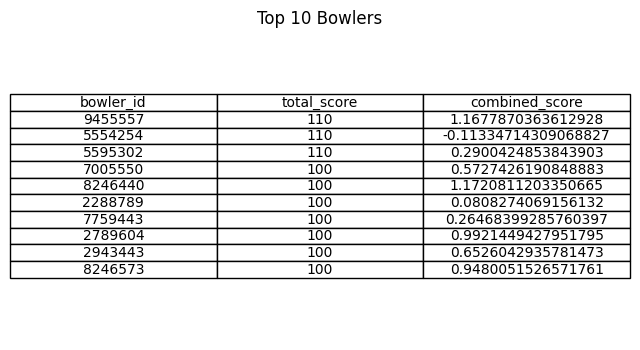

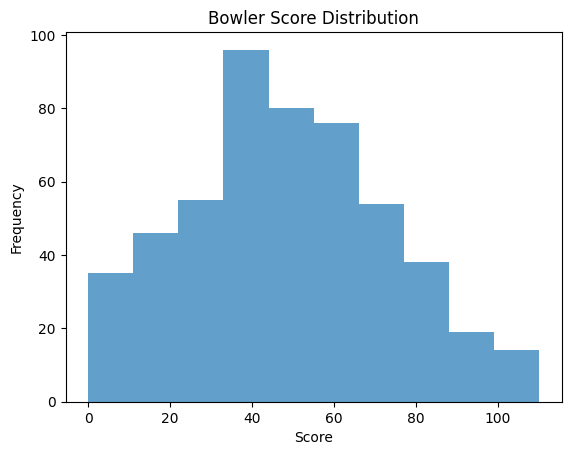

In [ ]:
#Filter bowlers
bowlers = bow_data[bow_data['total_wickets_taken'] >= 10].sort_values('total_score', ascending=False)[['bowler_id','total_score','combined_score']].head(10)
fig, ax = plt.subplots(figsize=(8, 4))  # Set figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=bowlers.values, colLabels=bowlers.columns, cellLoc='center', loc='center')
plt.title('Top 10 Bowlers')
# Save the table as an image
plt.savefig('bat.png', bbox_inches='tight', dpi=300)
plt.show()
plt.hist(bow_data[bow_data['total_wickets_taken'] >= 10]['total_score'], bins=10, alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Bowler Score Distribution')
plt.show()

3 Bowlers have a score of 110 so we select all of them

<ipython-input-17-8a2d955c7314>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allRound['total_score'] = allRound['total_score_batsman'] + allRound['total_score_bowler']


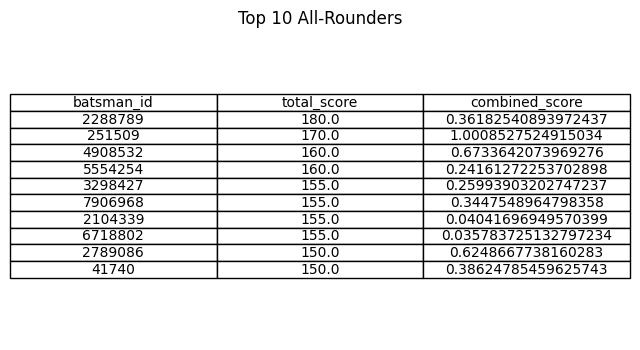

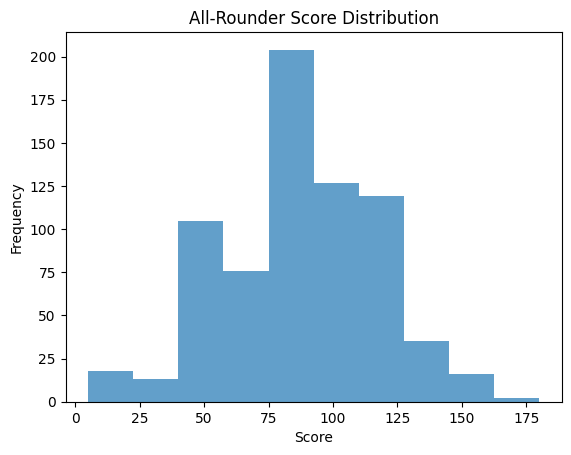

In [ ]:
# Merge based on batsman_id / bowler_id
merged = pd.merge(bat_data, bow_data, left_on='batsman_id', right_on='bowler_id', suffixes=('_batsman', '_bowler'), how='outer')
merged['batsman_id'] = merged['batsman_id'].fillna(merged['bowler_id'])

#All-rounder conditions
allRound = merged[(merged['total_runs'] > 10) & merged['wickets_in_2_or_more_matches']]
allRound['total_score'] = allRound['total_score_batsman'] + allRound['total_score_bowler']
allRound = allRound.sort_values('total_score', ascending=False)
allRound['combined_score'] = (allRound['combined_score_batsman'] + allRound['combined_score_bowler']) / 2

allrounder = allRound[['batsman_id','total_score','combined_score']].head(10)
fig, ax = plt.subplots(figsize=(8, 4))  # Set figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=allrounder.values, colLabels=allrounder.columns, cellLoc='center', loc='center')
plt.title('Top 10 All-Rounders')
# Save the table as an image
plt.savefig('bat.png', bbox_inches='tight', dpi=300)
plt.show()
plt.hist(allRound['total_score'], bins=10, alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('All-Rounder Score Distribution')
plt.show()


In [ ]:
#We need to select one all rounder with score 155 as one all rounder with score 160 has already been selected as a bowler so we get their combined consistency and recency scores
allrounder[allrounder['total_score'] == 155].sort_values(by=['combined_score'], ascending=False)

,batsman_id,total_score,combined_score
1558,7906968,155.0,0.344755
624,3298427,155.0,0.259939
277,2104339,155.0,0.040417
1300,6718802,155.0,0.035784


In [ ]:
#Get stats of selected 11
merged[merged['batsman_id'].isin([9455557,
5554254,
5595302,
2263736,
1749075,
3125562,
2275195,
2288789,
251509,
4908532,
7906968])][['batsman_id','total_runs','strike_rate_batsman','average_batsman','hundreds','fifties','total_wickets_taken','strike_rate_bowler','economy','average_bowler','four_wicket_hauls']]

,batsman_id,total_runs,strike_rate_batsman,average_batsman,hundreds,fifties,total_wickets_taken,strike_rate_bowler,economy,average_bowler,four_wicket_hauls
65,251509,42,190.909091,42.0,0.0,0.0,5,12.0,3.2,6.4,0.0
197,1749075,3203,153.621103,31.097087,3.0,20.0,<NA>,<NA>,<NA>,<NA>,NaN
337,2263736,4031,130.74927,55.986111,2.0,38.0,<NA>,<NA>,<NA>,<NA>,NaN
341,2275195,2480,154.806492,30.617284,3.0,14.0,36,24.5,7.85034,32.055556,0.0
350,2288789,729,138.068182,36.45,1.0,5.0,41,13.439024,6.871143,15.390244,1.0
574,3125562,2551,158.25062,35.430556,4.0,19.0,<NA>,<NA>,<NA>,<NA>,NaN
1021,4908532,119,107.207207,59.5,0.0,0.0,3,14.0,5.285714,12.333333,0.0
1114,5554254,795,148.876404,13.032787,0.0,1.0,175,17.011429,6.75781,19.16,6.0
1123,5595302,8,47.058824,2.0,0.0,0.0,21,11.428571,5.175,9.857143,2.0
1558,7906968,493,132.526882,44.818182,0.0,2.0,17,15.529412,6.704545,17.352941,1.0
